In [1]:
# Code to install Unsloth, Triton, Torch etc
# %%capture
# !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
# !pip install --no-deps cut_cross_entropy unsloth_zoo
# !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
# !pip install --no-deps unsloth

In [2]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os

major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = major_version >= 8
from inspect import currentframe as _C, getframeinfo

_F = lambda c: getframeinfo(c).lineno  # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m")  # Red colored warnings


# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""


def assert_same(x, y, line, dtype):
    assert x.dtype == dtype
    try:
        torch.testing.assert_close(x, y, check_stride=True)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )


os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

---
---
---
<a name="NF4"></a>
## A) Convert `nf4` to Triton. [Difficulty: Hard] [Max points: 14]

1. Goal: Convert a `nf4` quantized tensor into `fp16` or `bf16` into a *single* Triton kernel The double dequant of the `absmax` and weight forming must be done in 1 Triton kernel. Must work on Tesla T4.
2. Must be faster than Unsloth's `fast_dequantize` by 1.15x or more, and not use large intermediate memory buffers.
3. Must not use `torch.compile`, but can use `trace.enabled` to help on writing Triton kernels.
4. Good material: [Unsloth `fast_dequantize` function](https://github.com/unslothai/unsloth/blob/main/unsloth/kernels/utils.py#L128), also [bitsandbytes `dequantize_blockwise`](https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L958)
5. Use `test_dequantize_function` to test your implementation.
6. No CUDA allowed. Custom CUDA inside of the Triton is allowed.
7. Watch Tim's videos on Youtube: [8-bit Optimizers](https://www.youtube.com/watch?v=2ETNONas068)

### Marking Criteria for A) Max points = 14
```python
if attemped_A:
    A_score = 0
    if single_triton_kernel: A_score += 3
    speedup = old_time / new_time
    if speedup <= 1.00: A_score -= 3
    if speedup >= 1.05: A_score += 1
    if speedup >= 1.10: A_score += 2
    if speedup >= 1.15: A_score += 2
    if kernel_works_in_torch_compile: A_score += 1
    else: A_score -= 1
    if custom_asm_works: A_score += 3
    if uses_cache_eviction: A_score += 1
    if tested_in_f16_and_bf16: A_score += 1
    else: A_score -= 1
    final_score += A_score
else:
    final_score += 0
```

In [3]:
from bitsandbytes.nn import Linear4bit
from transformers.activations import ACT2FN
from unsloth.kernels.utils import fast_dequantize
import triton


def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)


def bnb_Linear4bit(hd, m, dtype=torch.float16):
    return Linear4bit(
        hd,
        m,
        bias=None,
        compute_dtype=dtype,
        compress_statistics=True,
        quant_type="nf4",
    )


class MLP(nn.Module):
    def __init__(self, hd=4096, m=14336, dtype=torch.float16):
        super().__init__()
        self.gate_proj = bnb_Linear4bit(hd, m, dtype=dtype)
        self.up_proj = bnb_Linear4bit(hd, m, dtype=dtype)
        self.down_proj = bnb_Linear4bit(m, hd, dtype=dtype)
        self.act_fn = ACT2FN["silu"]

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))


def mlp_forward(X, mlp, fx):
    up = X @ fx(mlp.up_proj).t()
    gate = X @ fx(mlp.gate_proj).t()
    h = mlp.act_fn(gate) * up
    down = h @ fx(mlp.down_proj).t()
    return down


def mlp_dequantize(X, mlp, fx):
    a = fx(mlp.up_proj).t()
    torch.cuda.synchronize()
    b = fx(mlp.gate_proj).t()
    torch.cuda.synchronize()
    c = fx(mlp.down_proj).t()
    torch.cuda.synchronize()
    return a, b, c


def test_dequantize(dequantize_fx):
    elapsed = 0
    options = [
        (5, 777, 1024, 4096, 3409, torch.bfloat16),
        (3, 2048, 4096, 14336, 3408, torch.bfloat16),
        (2, 3333, 2048, 8192, 3407, torch.float16),
    ]
    for bsz, qlen, hd, m, seed, dt in options:
        set_seed(seed)
        torch.set_default_dtype(dt)
        mlp = MLP(hd=hd, m=m, dtype=dt).to("cuda")
        X = torch.randn((bsz, qlen, hd), device="cuda")
        torch.cuda.synchronize()

        # Warmup
        for _ in range(2):
            assert_same(mlp_forward(X, mlp, dequantize_fx), mlp(X), _F(_C()), dt)
            a, b, c = mlp_dequantize(X, mlp, dequantize_fx)
            A, B, C = mlp_dequantize(X, mlp, unsloth_dequantize)
            assert_same(a, A, _F(_C()), dt)
            assert_same(b, B, _F(_C()), dt)
            assert_same(c, C, _F(_C()), dt)

        # Benchmarking
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000):
            mlp_dequantize(X, mlp, dequantize_fx)
        elapsed += time.time() - start
    return elapsed

    


/tmp/ipykernel_22184/3913609589.py:3: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.kernels.utils import fast_dequantize


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Testing the unsloth reference implementation

In [4]:
from unsloth.kernels.utils import fast_dequantize


def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)


test_dequantize(unsloth_dequantize)

2.2213265895843506

My triton implementation

In [11]:
import triton
import triton.language as tl

@triton.jit
def dequantize_nf4_code(code_index):
    """Helper function to dequantize a 4-bit NF4 code to its float value."""
    bit3 = (code_index & 0x8) != 0  # Check if bit 3 is set (8)
    bit2 = (code_index & 0x4) != 0  # Check if bit 2 is set (4)
    bit1 = (code_index & 0x2) != 0  # Check if bit 1 is set (2)
    bit0 = (code_index & 0x1) != 0  # Check if bit 0 is set (1)
    # (bit3, bit2, bit1, bit0) = tl.inline_asm_elementwise(
    #     asm="""
    #     // Extract bit 3
    #     bfe.u32 $0, $4, 3, 1;
    #     // Extract bit 2
    #     bfe.u32 $1, $4, 2, 1;
    #     // Extract bit 1
    #     bfe.u32 $2, $4, 1, 1;
    #     // Extract bit 0
    #     bfe.u32 $3, $4, 0, 1;
    #     """,
    #     constraints="=r,=r,=r,=r,r",  # 4 outputs, 1 input
    #     args=[code_index],
    #     pack=1,
    #     dtype=(tl.int8, tl.int8, tl.int8, tl.int8),
    #     is_pure=True,
    # )
    # bit3, bit2, bit1, bit0 = bit3 != 0, bit2 != 0, bit1 != 0, bit0 != 0

    # we avoid reading the code values directly, as they are not contiguous.
    # plus, the code values provided with linear4bit aren't exactly the same as the ones used by bnb
    # taken from bitsandbytes get_4bit_type to ensure we use the same values
    # https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L1075

    return tl.where(bit3,
        # 1xxx
        tl.where(bit2,
            # 11xx
            tl.where(bit1,
                # 111x
                tl.where(bit0, 1.0, 0.7229568362236023),
                # 110x
                tl.where(bit0, 0.5626170039176941, 0.44070982933044434)
            ),
            # 10xx
            tl.where(bit1,
                # 101x
                tl.where(bit0, 0.33791524171829224, 0.24611230194568634),
                # 100x
                tl.where(bit0, 0.16093020141124725, 0.07958029955625534)
            )
        ),
        # 0xxx
        tl.where(bit2,
            # 01xx
            tl.where(bit1,
                # 011x
                tl.where(bit0, 0.0, -0.09105003625154495),
                # 010x
                tl.where(bit0, -0.18477343022823334, -0.28444138169288635)
            ),
            # 00xx
            tl.where(bit1,
                # 001x
                tl.where(bit0, -0.39491748809814453, -0.5250730514526367),
                # 000x
                tl.where(bit0, -0.6961928009986877, -1.0)
            )
        )
    )

@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 128}),
        triton.Config({'BLOCK_SIZE': 256}),
        triton.Config({'BLOCK_SIZE': 512}),
        triton.Config({'BLOCK_SIZE': 1024}),
        triton.Config({'BLOCK_SIZE': 2048}),
        triton.Config({'BLOCK_SIZE': 4096}),
        triton.Config({'BLOCK_SIZE': 8192}),
    ],
    key=['total_elements'],
)
@triton.jit()
def _your_dequantize_nf4_kernel(
    weight_ptr,  # [uint8]  Quantized weights, 1 byte => 2 NF4 elements
    absmax_ptr,  # [int]  One int "index" per element
    absmax2_ptr,  # [float]  One absmax2 per block
    code_ptr,  # [float]  NF4 code lookup
    code2_ptr,  # [float]  Absmax code lookup
    offset_ptr,  # [float]  Offset to add after absmax is decoded
    out_ptr,  # [float]  Final dequantized output
    weight_blocksize: tl.constexpr,  # [int]   Number of elements in a weight block
    absmax_blocksize: tl.constexpr, # [int]   Number of elements in a absmax block
    total_elements: tl.constexpr,  # [int]   Number of actual float elements to reconstruct
    BLOCK_SIZE: tl.constexpr,
    # debug_absmax_ptr=None,
    # debug_quant1_ptr=None,
    # debug_quant2_ptr=None,
):
    # context; we adopt the pov of a quantized byte, which corresponds to 2 elems
    pid = tl.program_id(0)
    start = pid * BLOCK_SIZE
    index = start + tl.arange(0, BLOCK_SIZE)

    offset = tl.load(offset_ptr, eviction_policy="evict_last")

    # weight_block_index = index // (weight_blocksize // 2) # the block index of the byte
    # now we end up with a vector like (0, 0, ... 0, 0, 1, 1, ...)
    # we can shrink this by applying a stride of weight_blocksize // 2
    weight_block_index = start // (weight_blocksize // 2) + tl.arange(0, BLOCK_SIZE // (weight_blocksize // 2))
    absmax_block_index = weight_block_index // absmax_blocksize # the block index of the absmax

    # mask calculations
    byte_index_mask = index < (total_elements // 2)
    weight_block_mask = weight_block_index < (total_elements // weight_blocksize) 
    abs_block_mask = absmax_block_index < (total_elements // weight_blocksize // absmax_blocksize)

    # compute absmax for the block these weights belong to:
    absmax1_code = tl.load(absmax_ptr + weight_block_index, mask=weight_block_mask, eviction_policy="evict_first")
    absmax1_code = absmax1_code.to(tl.int16) # this is necessary
    
    # reading values from code is likely a very slow process due to lack of contiguity
    absmax1_val = tl.load(code2_ptr + absmax1_code, mask=(absmax1_code < 256), eviction_policy="evict_first")
    absmax2_val = tl.load(absmax2_ptr + absmax_block_index, mask=abs_block_mask)
    
    absmax = tl.fma(absmax1_val, absmax2_val, offset)

    # lookup each weight bit
    byte = tl.load(weight_ptr + index, mask=byte_index_mask, eviction_policy="evict_first").to(tl.uint8)

    # matter of covention which set of bits is the first and second
    code_index2 = byte & 0x0F  # Lower 4 bits
    code_index1 = (byte >> 4) & 0x0F  # Upper 4 bits

    # we can interleave the codes to get back to using just one large tensor
    # might need to assess if interleaving is the fastest op (or some cat/join + reshape is faster)
    # weight_index = tl.interleave(index * 2, index * 2 + 1)
    # weight_index_mask = weight_index < total_elements

    # code = tl.interleave(code_index1, code_index2)
    # weight = dequantize_nf4_code(code)[:, None, None].reshape(BLOCK_SIZE // weight_blocksize * 2, weight_blocksize) * absmax[:, None]
    # # code = tl.join(code_index1, code_index2)
    # weight = dequantize_nf4_code(code)[:, :, None].reshape(BLOCK_SIZE // (weight_blocksize // 2), (weight_blocksize // 2), 2) * absmax[:, None]


    # # weight_index = tl.ravel(tl.join(index * 2, index * 2 + 1))
    # tl.store(out_ptr + weight_index, tl.ravel(weight), mask=weight_index_mask, cache_modifier=".cs")

    # Dequantize both 4-bit values
    weight1 = dequantize_nf4_code(code_index1)[:, None].reshape(BLOCK_SIZE // (weight_blocksize // 2), (weight_blocksize // 2)) * absmax[:, None]
    weight2 = dequantize_nf4_code(code_index2)[:, None].reshape(BLOCK_SIZE // (weight_blocksize // 2), (weight_blocksize // 2)) * absmax[:, None]
    
    tl.store(out_ptr + (index * 2), tl.ravel(weight1), mask=byte_index_mask, cache_modifier=".cs")
    tl.store(out_ptr + (index * 2 + 1), tl.ravel(weight2), mask=byte_index_mask, cache_modifier=".cs")

    tl.debug_barrier()
    


def _your_dequantize_nf4(weight, quant_state):
    absmax = quant_state.absmax
    code = quant_state.code
    shape = quant_state.shape
    dtype = quant_state.dtype
    blocksize = quant_state.blocksize
    offset = quant_state.offset
    state2 = quant_state.state2
    absmax2 = state2.absmax
    code2 = state2.code
    blocksize2 = state2.blocksize

    out = torch.empty(shape, dtype=dtype, device=weight.device)
    weight_grid = lambda meta: (triton.cdiv(out.numel() // 2, meta['BLOCK_SIZE']),)

    _your_dequantize_nf4_kernel[weight_grid](
        weight,
        absmax,
        absmax2,
        code,
        code2,
        offset,
        out,
        weight_blocksize=blocksize,
        absmax_blocksize=blocksize2,
        total_elements=out.numel(),
        # BLOCK_SIZE=TL_BLOCKSIZE,
    )

    # apparently, the fact that it could need a transpose is already handled
    return out

def your_dequantize_nf4(weight):
    return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)



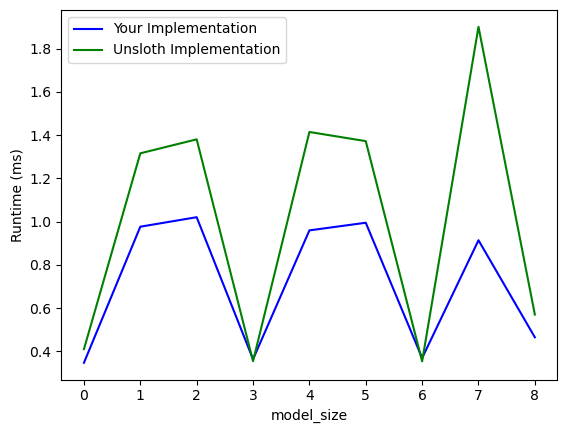

dequantize_performance:
       model_size  Your Implementation  Unsloth Implementation
0      small_bf16             0.347495                0.410651
1     medium_bf16             0.976527                1.315784
2      large_bf16             1.020464                1.380458
3   small_float16             0.363867                0.354857
4  medium_float16             0.959532                1.414418
5   large_float16             0.994844                1.372085
6           case1             0.369290                0.354112
7           case2             0.913896                1.900701
8           case3             0.465191                0.570429


In [12]:
size_map = {
        "small_bf16": (5, 777, 1024, 4096, torch.bfloat16, 3410),
        "medium_bf16": (3, 2048, 4096, 14336, torch.bfloat16, 3400),
        "large_bf16": (12, 1024, 4096, 16384, torch.bfloat16, 3390),
        "small_float16": (5, 777, 1024, 4096, torch.float16, 3410),
        "medium_float16": (3, 2048, 4096, 14336, torch.float16, 3400),
        "large_float16": (12, 1024, 4096, 16384, torch.float16, 3390),
        "case1": (5,  777, 1024,  4096, torch.bfloat16, 3409),
        "case2": (3, 2048, 4096, 14336, torch.bfloat16, 3408),
        "case3": (2, 3333, 2048,  8192, torch.float16, 3407),
    }

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['model_size'],  # Use a single parameter for the x-axis
        x_vals=list(size_map.keys()),
        line_arg='provider',
        line_vals=[
            'your_dequantize',
            'unsloth_dequantize',
        ],
        line_names=[
            'Your Implementation',
            'Unsloth Implementation',
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='Runtime (ms)',
        plot_name='dequantize_performance',
        args={},  # Empty dict for additional args
    )
)
def bench_dequantize(model_size, provider):
    # Map model size to configuration
    bsz, qlen, hd, m, dtype, seed = size_map[model_size]
    
    set_seed(seed)
    torch.set_default_dtype(dtype)
    mlp = MLP(hd=hd, m=m, dtype=dtype).to("cuda")
    X = torch.randn((bsz, qlen, hd), device="cuda")
    
    # Select the dequantization function based on provider
    dequantize_fx = your_dequantize_nf4 if provider == 'your_dequantize' else unsloth_dequantize
    
    # Benchmark
    ms = triton.testing.do_bench(
        lambda: mlp_dequantize(X, mlp, dequantize_fx),
        warmup=20,
        rep=50
    )
    
    return ms

    
bench_dequantize.run(print_data=True, show_plots=True)

In [13]:
### CALCULATE SPEEDUP (hopefully 1.15x faster or more)
test_dequantize(unsloth_dequantize) / test_dequantize(your_dequantize_nf4)

1.2759167632088424